In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat, savemat
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
%matplotlib inline

In [5]:
def getImages(impath, labelpath):
    imgs = loadmat(impath)['img_mat'][0]
    labels = loadmat(labelpath)
    labels = np.squeeze(labels['data']['truth'][0,0])
    prepped_imgs = []
    for i in range(imgs.shape[0]):
        img = Image.fromarray(imgs[i]).resize([224,224])
        rgb_img = Image.new("RGB", img.size)
        rgb_img.paste(img)
        prepped_imgs.append(np.array(rgb_img))
                                              
    prepped_imgs = np.array(prepped_imgs)
    prepped_imgs = np.transpose(prepped_imgs,(0,3,1,2))
    return prepped_imgs, labels

def polarize(tensor):
    tensor = tensor.detach().numpy()
    tensor[tensor>0]=1
    tensor[tensor<0]=-1
    return tensor

In [53]:
imgs = loadmat('occluded_imgs.mat')['dataset']
imgs[0,0].shape

(42, 227, 227, 3)

In [3]:
__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# define original alexnet
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.fc7 = None

    # modify forward to spit out softmax, fc7, and pool 5 for convenience
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        y = self.classifier(x)
        z = self.fc7(x)
        return {"softmax" : y, "p5" : x, "fc7" : z}


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

# get pretrained alexnet
model = alexnet(pretrained=True)

# get rid of dropout layers; they make results of forward stochastic.
sel = [1,2,4,5,6]
model.classifier = nn.Sequential(*[list(model.classifier.children())[i] for i in sel])

# define fc7 pass
sel = [0,1,2]
model.fc7 = nn.Sequential(*[list(model.classifier.children())[i] for i in sel])
model.children

<bound method Module.children of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=4096, out_features=4096, bias=Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


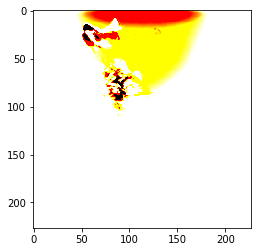

In [58]:
plt.imshow(np.transpose(imgs[0,0][4],(1,0,2)))

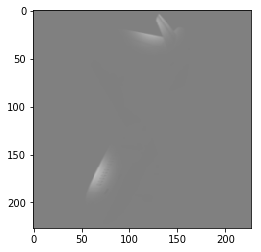

In [22]:
plt.imshow(imgs[0,0][0]/255)

In [15]:
out = model.forward(torch.tensor(np.transpose(imgs[0,0],(0,3,1,2))).float())

In [17]:
out['softmax']

torch.Size([42, 1000])

In [6]:
# get whole images 
impath = '../occlusion-classification/data/KLAB325.mat'
labelpath = '../occlusion-classification/data/data_occlusion_klab325v2_origimages.mat'

X,y = getImages(impath,labelpath)

# split data into test and train
rs = ShuffleSplit(n_splits=1, test_size=.5, random_state=0)
for train_index, test_index in rs.split(X):
    X_train = torch.tensor(X[train_index]).float()
    y_train = y[train_index]
    X_test = torch.tensor(X[test_index]).float()
    y_test = y[test_index]

In [4]:
# get alexnet features for test and train data
X_out_train = model.forward(X_train)
X_out_test = model.forward(X_test)
fc7_train = polarize(X_out_train['fc7'])
fc7_test = polarize(X_out_test['fc7'])

# train svm on fc7 representations
lin_clf = svm.LinearSVC()
lin_clf.fit(fc7_train, y_train) 

# classify fc7 test representations
dec = lin_clf.decision_function(fc7_test)
y_hat = [hot.argmax()+1 for hot in dec]

# quantify accuracy
correct = [1 if y_hat[i]==y_test[i] else 0 for i in range(len(y_hat))]
sum(correct)/len(correct)

0.8159509202453987

In [5]:
# get occluded images 
impath = '../occlusion-classification/data/KLAB325-occluded.mat'
labelpath = '../occlusion-classification/data/data_occlusion_klab325v2_origimages.mat'

X_occ,y_occ = getImages(impath,labelpath)

# use train / test index from unoccluded
X_train_occ = torch.tensor(X_occ[train_index]).float()
y_train_occ = y_occ[train_index]
X_test_occ = torch.tensor(X_occ[test_index]).float()
y_test_occ = y_occ[test_index]

# get alexnet features for test and train data
X_out_train_occ = model.forward(X_train_occ)
X_out_test_occ = model.forward(X_test_occ)
fc7_train_occ = polarize(X_out_train_occ['fc7'])
fc7_test_occ = polarize(X_out_test_occ['fc7'])

# use prior svm train on full images
# lin_clf = svm.LinearSVC()
# lin_clf.fit(fc7_train, y_train) 

# classify fc7 test representations
dec_occ = lin_clf.decision_function(fc7_test_occ)
y_hat_occ = [hot.argmax()+1 for hot in dec_occ]

# quantify accuracy
correct = [1 if y_hat_occ[i]==y_test_occ[i] else 0 for i in range(len(y_hat_occ))]
sum(correct)/len(correct)

0.24539877300613497

In [ ]:
savemat('../occlusion-classification/data/fc7_features.mat', {
    'fc7_train':fc7_train,
    'fc7_test':fc7_test,
    'fc7_train_occ':fc7_train_occ,
    'fc7_test_occ':fc7_test_occ,
    'train_labels':y_train,
    'test_labels':y_test
})

ugh, now run 'featureAttractors.m', which will generate the hopfield network and run fc7_test and tc7_test_occ for 256 timesteps, saving the results to 'fc7_hop_trajs.mat'

In [55]:
fc7_hop_trajs = loadmat('fc7_hop_trajs.mat')
fc7_hop_trajs.keys()

dict_keys(['__header__', '__version__', '__globals__', 'fc7_test_hop_trajs', 'fc7_test_occ_hop_trajs'])

In [54]:
fc7_trajs = fc7_hop_trajs['fc7_test_hop_trajs']
fc7_trajs.shape

(163, 7, 4096)

In [52]:
fc7_trajs[0,:,2]

array([-1., -1., -1., -1., -1., -1., -1.])